<a href="https://colab.research.google.com/github/RomanGustavo/Mestrado---ML/blob/main/codigo_aula18_classificacao_multi_classe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação multi-classe com tensorflow


Nessa atividade de programação, exploraremos a função Softmax.
Essa função é usada tanto na Regressão Softmax como também em redes neurais para resolver problemas de classificação onde temos múltiplas classes.


  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from IPython.display import display, Markdown, Latex
from sklearn.datasets import make_blobs

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

> **OBS**: Normalmente, nos nossos notebooks, nós usamos a convenção de começar a contagem de índices em 0 e terminar em $N-1$, enquanto que nos slides da disciplina a contagem se inicia em 1 e termina em $N$. No presente notebook, usaremos a mesma notação que está nos slides para facilitar a compreensão.


## A função Softmax

Tanto na Regressão Softmax como nas redes neurais com saídas softmax, $N$ saídas são geradas e uma é selecionada como a categoria (classe) prevista. Em ambos os casos, um vetor $\mathbf{z}$, gerado por uma função linear é aplicado à função Softmax. A função softmax converte $\mathbf{z}$ em uma distribuição de probabilidade conforme descrito abaixo. Após aplicar softmax, cada saída estará entre 0 e 1 e as saídas somam 1, tal que essas saídas podem ser interpretadas como sendo probabilidades. Quanto maior forem as entradas, maiores são as probabilidades de saída.

A função Softmax pode ser escrita como sendo:
$$a_j = \frac{e^{z_j}}{ \sum_{k=1}^{N}{e^{z_k} }} \tag{1}$$

A saída $\mathbf{a}$ é um vetor de tamanho $N$, e pode ser interpretada da seguinte forma:
\begin{align}
\mathbf{a}(x) =
\begin{bmatrix}
P(y = 1 | \mathbf{x}; \mathbf{w},b) \\
\vdots \\
P(y = N | \mathbf{x}; \mathbf{w},b)
\end{bmatrix}
=
\frac{1}{ \sum_{k=1}^{N}{e^{z_k} }}
\begin{bmatrix}
e^{z_1} \\
\vdots \\
e^{z_{N}} \\
\end{bmatrix} \tag{2}
\end{align}


Isso mostra que as saídas são um vetor contendo probabilidades. A primeira saída (primeiro elemento do vetor) é a probabilidade de ser a primeira categoria dado o vetor de características de entrada $\mathbf{x}$ e parâmetros $\mathbf{w}$ e $\mathbf{b}$.  

Abaixo nós criamos nossa própria implementação NumPy da função Softmax:

In [2]:
def minha_softmax(z):
    ez = np.exp(z)              # exponencial elemento a elemento
    sm = ez/np.sum(ez)
    return(sm)

Supondo um problema com $N=4$ classes, use o código abaixo para testar e verificar as saídas da função softmax ($a_1$,$a_2$,$a_3$,$a_4$) para diferentes combinações de valores de entrada ($z_1$,$z_2$,$z_3$,$z_4$)

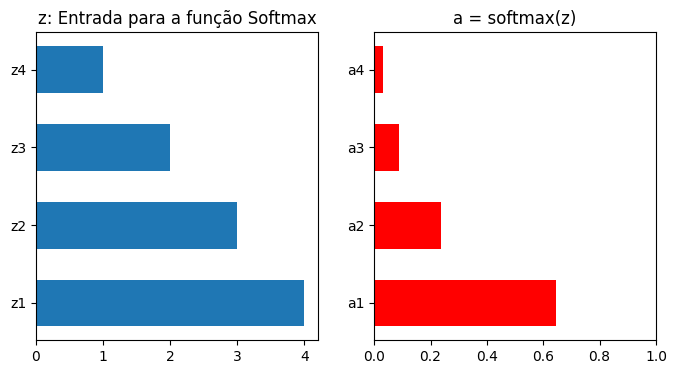

Soma das saídas softmax (a1+a2+a3+a4): 1.0


In [3]:
z4 = 1
z3 = 2
z2 = 3
z1 = 4

plt.close("all")

fig, ax = plt.subplots(1,2,figsize=(8,4))

z       = np.array([z1,z2,z3,z4])
z_nomes = np.array(['z1','z2','z3','z4'])
bar     = ax[0].barh(z_nomes, height=0.6, width=z, left=None, align='center')
ax[0].set_title("z: Entrada para a função Softmax")

a       = minha_softmax(z)
a_nomes = np.array(['a1','a2','a3','a4'])
sbar    = ax[1].barh(a_nomes, height=0.6, width=a, left=None, align='center',color='red')
ax[1].set_xlim([0,1])
ax[1].set_title("a = softmax(z)")

plt.show()

print(f'Soma das saídas softmax (a1+a2+a3+a4): {np.sum(a)}')

Conforme você varia os valores de z acima, algumas observações são importantes:
* os valores de saída (probabilidades) sempre somam 1
* a função softmax altera todas as saídas simultaneamente. Por exemplo, uma mudança em `z1` não altera apenas `a1`, mas também `a2`,`a3`,`a4`. Isso não ocorre quando usamos outras funções de ativação conhecidas, tais como ReLU ou sigmoide, que esbelecem relações do tipo uma-entrada-uma-saída.

## Função Custo

A função perda associada ao uso da função Softmax é a função de entropia cruzada para $N$ classes, isto é:

\begin{equation}
  L(\mathbf{a},y)=\begin{cases}
    -log(a_1), & \text{se $y=1$}.\\
        &\vdots\\
     -log(a_N), & \text{se $y=N$}
  \end{cases} \tag{3}
\end{equation}

onde $y$ é a categoria alvo para esse exemplo e $\mathbf{a}$ é a saída da função Softmax. Mais especificamente, Os valores em $\mathbf{a}$ são as probabilidades que somam 1.


>**Lembre-se:** A Perda se refere apenas a uma amostra, enquanto que o *custo* leva em conta todas as amostras.


Note que na equação (3) acima, apenas a linha que corresponde ao alvo contribui para a perda, enquanto as demais linhas são ignoradas. Para escrever o custo nós precisamos de uma 'função indicadora' que será 1 quando o índice coincide com o alvo e zero caso contrário:

\begin{equation}
1\{y == n\} =\begin{cases}
    1, & \text{se $y==n$}.\\
    0, & \text{caso contrário}.
  \end{cases}
\end{equation}

  
Com essa definição, a função custo pode ser agora escrita conforme abaixo:
\begin{align}
J(\mathbf{w},b) = -\frac{1}{m} \left[ \sum_{i=1}^{m} \sum_{j=1}^{N}  1\left\{y^{(i)} == j\right\} \log \frac{e^{z^{(i)}_j}}{\sum_{k=1}^N e^{z^{(i)}_k} }\right] \tag{4}
\end{align}

onde $m$ é o número de amostras, $N$ é o número de saídas (classes). Note que a função custo nada mais é que a média das perdas.

## Tensorflow

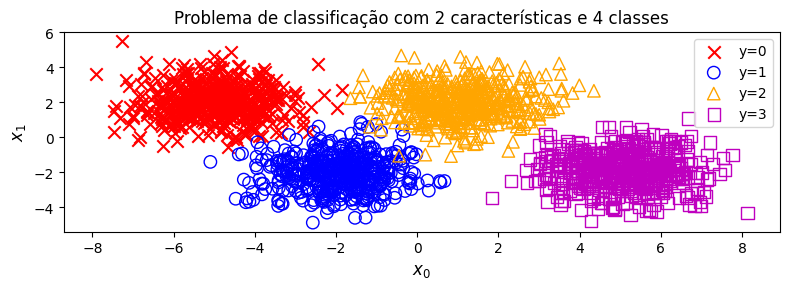

In [4]:
# Criando conjunto de dados e plotando
centros          = [[-5, 2], [-2, -2], [1, 2], [5, -2]] # Assim teremos 2 características e 4 classes (classes 0,1,2,3)
X_trein, y_trein = make_blobs(n_samples=2000, centers=centros, cluster_std=1.0,random_state=30)

classe0  = y_trein == 0
classe1  = y_trein == 1
classe2  = y_trein == 2
classe3  = y_trein == 3

fig,ax = plt.subplots(1,1,figsize=(8,3))
ax.scatter(X_trein[classe0,0], X_trein[classe0,1], marker='x', s=80, c = 'red', label="y=0")
ax.scatter(X_trein[classe1,0], X_trein[classe1,1], marker='o', s=80, label="y=1", facecolors='none', edgecolors='b',lw=1)
ax.scatter(X_trein[classe2,0], X_trein[classe2,1], marker='^', s=80, label="y=2", facecolors='none', edgecolors='orange',lw=1)
ax.scatter(X_trein[classe3,0], X_trein[classe3,1], marker='s', s=80, label="y=3", facecolors='none', edgecolors='m',lw=1)
ax.set_ylabel('$x_1$', fontsize=12)
ax.set_xlabel('$x_0$', fontsize=12)
ax.set_title('Problema de classificação com 2 características e 4 classes')
ax.legend()
plt.tight_layout()
plt.show()

### Implementação intuitiva

O modelo abaixo é implementado com a função softmax funcionando como uma ativação na camada Dense final.
A função perda é especificada separadamente por meio do comando `compile`.

A função perda é a função de entropia cruzada, denominada `SparseCategoricalCrossentropy`. Ela implementa a equação (3) acima.
A função perda recebe as saídas da função softmax (vetor de probabilidades para cada classe) e computa a perda associada.

In [5]:
modelo = Sequential(
    [
        Dense(25, activation = 'relu'),
        Dense(15, activation = 'relu'),
        Dense(4, activation = 'softmax')    # < Note a função de ativação softmax aqui
    ]
)
modelo.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

modelo.fit(
    X_trein,y_trein,
    epochs=10
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3108
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6566
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2870
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1431
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0961
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0751
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0649
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0531
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0513
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0489


Uma vez que a função softmax encontra-se integrada à camada de saída, sua saída já é o vetor de probabilidades (números entre 0 e 1), conforme mostrado abaixo. Note que temos quatro probabilidades para cada exemplo de treinamento em X_train. Esses quatro valores denotam a probabilidade da respectiva amostra pertencer a cada uma das quatro classes ($y=0,1,2,3$)

In [6]:
i = 3
probabilidades = modelo.predict(X_trein[i,:].reshape(1,-1)) # calcula a saída da rede neural para o exemplo de treinamento i
print(probabilidades)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
[[0.00812131 0.9751094  0.00144527 0.01532413]]


Note que as saídas do nosso modelo são de fato valores entre 0 e 1 (probabilidades). Para retornar um valor inteiro representando a classe prevista, basta você verificar o índice (posição) com a maior probabilidade. Isso pode ser obtido com a função Numpy [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) function.

In [7]:
yhat = np.argmax(probabilidades)

print(f"np.argmax(probabilidades) = classe estimada: {yhat}")
print(f"classe verdadeira: {y_trein[i]}")

np.argmax(probabilidades) = classe estimada: 1
classe verdadeira: 1


Seguindo as ideias acima, abaixo nós calculamos a taxa de acerto levando em conta todas as amostras do nosso conjunto de dados.

In [8]:
Probabilidades = modelo.predict(X_trein) # calcula a saída da rede neural para o exemplo de treinamento i

print("maior probabilidade:", np.max(Probabilidades), "     menor probabilidade:", np.min(Probabilidades))

Yhat        = np.argmax(Probabilidades,axis=1)
taxa_acerto = np.mean((Yhat==y_trein)*100)
print(f"taxa de acerto (acurácia): {taxa_acerto} %")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
maior probabilidade: 0.9999985      menor probabilidade: 3.2030302e-11
taxa de acerto (acurácia): 98.5 %


## Quando usar 'SparseCategorialCrossentropy' e quando usar 'CategoricalCrossEntropy'?

O Tensorflow permite que você entre com dois possíveis tipos de formatação para os valores alvo e a seleção da função de perda define qual formatação está sendo esperada.
- SparseCategorialCrossentropy: Espera que o valor alvo para uma amostra seja um valor inteiro correspondente ao índice. Exemplo: temos 10 possíveis categorias, sendo $y = $ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9.
- CategoricalCrossEntropy: Espera que o valor alvo para uma amostra esteja codificado na forma `one-hot bit`, onde o índice alvo é 1 enquanto os demais valores são nulos. Por exemplo, quando há 10 categorias e y para a terceira categoria é $[0,0,1,0,0,0,0,0,0,0]$

## Parabéns!

Com essa atividade, você
- Tornou-se mais familiar com a função softmax e seu uso como função de ativação na última camada de redes neurais.
- Aprendeu a implementação mais robusta numericamente em Tensorflow:
    - Usar ativação linear na última camada
    - Usar SparseCategoricalCrossentropy como função perda
